##Auto Detection and Recognition of License Plates in Chinese City Parking Dataset.

University of Washington

EE P 595 Machine Learning for Cybersecurity

Final Project

Team: Blake Downey, Kail Luo, John Villanueva

## Project Imports and Drive Mounting


In [ ]:
%%capture
!pip install tensorflow
!pip install japanize-matplotlib

import os
import re
import cv2
import math
import imutils
import matplotlib
import numpy as np
import tensorflow as tf
from imutils import paths
import japanize_matplotlib
import matplotlib.pyplot as plt
from os.path import splitext, basename
from matplotlib.gridspec import GridSpec
from tensorflow.keras import Sequential, layers
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # mount the drive to access the data

Mounted at /content/drive


In [ ]:
images = '/content/drive/My Drive/UW/MLCS_595/CCPD-project/orig/'
cropped_images = '/content/drive/My Drive/UW/MLCS_595/CCPD-project/final_code/cropped_images/'
best_model = '/content/drive/My Drive/UW/MLCS_595/CCPD-project/models/best_rmsprop.epoch38-val_acc0.73.h5'

provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

plt.rcParams['font.sans-serif']=['SimHei'] #Show Chinese label
plt.rcParams['axes.unicode_minus']=False

## Classical CV method to go from original image to crop of the License Plate


In [ ]:
def license_plate(img):
  # convert to gray and blur
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blue = cv2.blur(gray, (3, 3))
  
  # Sharp image 
  sobel_img = cv2.Sobel(blue, cv2.CV_16S, 1, 0, ksize=3)
  sobel_img = cv2.convertScaleAbs(sobel_img)
  
  # BGR2HSV Determine LP color adjustment
  hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  h, s, v = hsv_img[:, :, 0], hsv_img[:, :, 1], hsv_img[:, :, 2]
  blue_img = (((h > 30) & (h <45)) | ((h > 80) & (h < 124))) & (s > 70) & (v > 70)
  blue_img = blue_img.astype('float32')

  # mix img
  mix_img = np.multiply(sobel_img, blue_img)
  mix_img = mix_img.astype(np.uint8)
  
  # Binary img
  _, binary_img = cv2.threshold(mix_img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

  # Expand and then corrode white area
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(21,5))
  close_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)

  return close_img
    

def cutoffimage(image,close_img):
  # Finding all possible places
  contours= cv2.findContours(close_img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contours = imutils.grab_contours(contours)
  
  # Get top 1
  if len(contours) ==0:
      return image
  contour = sorted(contours, key = cv2.contourArea, reverse = True)[0]
  
  # Get Perimeter and  area
  peri = cv2.arcLength(contour, True)
  approx = cv2.approxPolyDP(contour, 0.018 * peri, True)
  
  # Mask outside area black
  mask = np.zeros(close_img.shape,np.uint8)
  cv2.drawContours(mask,[approx],-1,255,-1)
  
  # Determine LP size
  (x, y) = np.where(mask == 255)
  (topx, topy) = (np.min(x), np.min(y))
  (bottomx, bottomy) = (np.max(x), np.max(y))
  Cropped = image[topx:bottomx+10, topy:bottomy+1]

  return Cropped

In [ ]:
orig_image_paths=list(paths.list_images(images))
images_array =[]
count = 0
for path in orig_image_paths:
  count += 1
  image=cv2.imread(path)[300:700,:,:]
  pre_image=license_plate(image)
  Cropped = cutoffimage(image,pre_image)
  name = ''.join(os.path.splitext(os.path.basename(path)))
  cv2.imwrite(cropped_images+name, Cropped)

## Data preparation for Deep Learning

In [ ]:
#####################################################################
#                                                                          HW 2 FUNCTIONS                                                                                    #
#####################################################################
'''
The functions within this section are not our original code and we are not claiming credit to them.
We are simply utilizing this code that we have used in a prior assignment and listing that clearly to avoid 
punishment of copywrite.
'''

def flatten(it):
    """ Flatten iterable of iterables into an iterable of values. """
    return (value for sub_it in it for value in sub_it)

def group_every(iterable, n_elem=1):
    """ Group every N elements into a list and yield that list. """
    group = []

    for value in iterable:
        # Add value to group
        group.append(value)
        # Yield and re-create group if it is full
        if len(group)>=n_elem:
            yield group
            group = []

    # Yield the last group if it's not empty
    if group:
        yield group


def unzip(iterable):
  """ Unzip iterable of tuples into tuple of lists. """
  unzip_lists = None
  n_lists = None
  
  for values in iterable:
      n_values = len(values)
      # Create lists from first tuple
      if unzip_lists is None:
          unzip_lists = tuple(([value] for value in values))
          n_lists = n_values
      else:
          # Check tuple length
          if n_values!=n_lists:
              raise ValueError(f"Expect tuple of {n_lists} values, got {n_values}")
          # Append values to lists
          for value, unzip_list in zip(values, unzip_lists):
              unzip_list.append(value)

  return unzip_lists

def print_images(images, n_rows=1, n_cols=None, fig_size=(20, 5), color_map="Greys",
  texts=None, font_size=20, text_center=(0.5, -0.2)):
  """ Print multiple images in a single Matplotlib figure (with optional text description). """
  n_images = len(images)
  n_cols = n_cols or math.ceil(n_images/n_rows)
  # Make grid plot for all images
  fig = plt.figure(figsize=fig_size)
  grid_spec = GridSpec(ncols=n_cols, nrows=n_rows)

  # Print each image
  for row in range(n_rows):
      for col in range(n_cols):
          i = row*n_cols+col
          # No more image to draw
          if i>=n_images:
              break

          # Get subplot for image
          ax = fig.add_subplot(grid_spec[row, col])
          ax.axis("off")
          # Plot image
          ax.imshow(images[i], cmap=color_map)
          # Plot text if available
          if texts:
              ax.text(
                  text_center[0], text_center[1], texts[i],
                  fontsize=font_size, transform=ax.transAxes,
                  ha="center", va="center"
              )
  
  # Apply tight layout
  fig.tight_layout()
  # Print figure
  print(fig)
#####################################################################
#                                                                       END HW 2 FUNCTIONS                                                                               #
#####################################################################

'''
Function to preprocess the images
'''
def preprocess_image(image,resize=False):
  #convert to grayscale
  img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  #convert image to binary and invert
  threshold, img_thresh = cv2.threshold(img_gray, 128, 255, cv2.THRESH_OTSU)
  img_invert = cv2.bitwise_not(img_thresh)
  
  # resize each to same size
  if resize:
      img_invert = cv2.resize(img_invert, (224, 32))
  
  #convert to numpy and return
  return np.array(img_invert)

'''
Function to extract the license plate chars and images from the cropped folder
'''
def extract(image_path):

  LP_images = []
  plates = []

  for path in image_path:
    #LP_images.append(img_to_array(load_img(path, color_mode='grayscale')))
    LP_images.append(preprocess_image(cv2.imread(path), resize=True))

    # get the base name of the file, split on '.' to remove extension
    base = os.path.splitext(os.path.basename(path))[0]

    # split on '-' to separate information
    base_split = base.split('-')

    # index the seven characters using the correct type: province, alphabets or ads
    LP = []
    LP_chars = base_split[4].split('_')
    LP.append(str(ord(provinces[int(LP_chars[0])])))
    LP.append(alphabets[int(LP_chars[1])])
    for i in range(2,len(LP_chars)):
        LP.append(ads[int(LP_chars[i])])
    plates.append(LP)

  return np.array(LP_images), plates

In [ ]:
# get the image paths for cropped images
cropped_image_paths = list(paths.list_images(cropped_images))

# using the extract function, load each cropped image and name into memory
LP_images, plates = extract(cropped_image_paths)

# Data Loader for the Images using ImageDataGenerator with no aug
image_transformer = ImageDataGenerator()

['30358', 'A', 'L', 'S', '7', '7', '8']


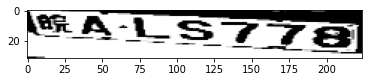

In [ ]:
'''
Example of plate and image
'''
num = 54
plt.imshow(LP_images[num], cmap='gray')

print(plates[num])

## Train Test Split and One Hot Encoding

In [ ]:
LP_images = np.reshape(LP_images, (-1, 32, 224,1))

# Training-validation-test split seed
SEED = 34

# Split dataset into training/validation and test sets
plate_images_tv, plate_images_test, plates_tv, plates_test = train_test_split(
    LP_images, plates, test_size=0.1, random_state=SEED
)

lb = LabelBinarizer()
# Flatten license plates into list of characters
plates_chars_tv = list(flatten(plates_tv))
# One-hot encode all license plate characters
plates_chars_ohe_tv = lb.fit_transform(plates_chars_tv)
n_classes = len(lb.classes_)
# Reshape one-hot labels for each license plate
plates_ohe = plates_chars_ohe_tv.reshape((-1, 7, n_classes))

# Split the training/validation data into train and validation
plate_images_train, plate_images_val, plates_train, plates_val = train_test_split(
    plate_images_tv, plates_ohe, test_size=0.1, random_state=SEED
)

## Define Network Architecture, Accuracy Metric and Train methods

In [ ]:
#####################################################################
#                                                                          HW 2 FUNCTION                                                                                      #
#####################################################################
'''
Again, this is a function taken from a previous homework assignment
Multi Accuracy using the one hot encoded vectors
'''
def multi_acc(actual_one_hot, pred_dist):
  # Get character classes for samples
  actual_classes = tf.argmax(actual_one_hot, axis=-1)
  pred_classes = tf.argmax(pred_dist, axis=-1)
  
  # Get correctness for prediction
  pred_correct = tf.reduce_all(tf.equal(actual_classes, pred_classes), axis=-1)
  pred_correct = tf.cast(pred_correct, dtype=pred_dist.dtype)
  
  # Compute accuracy
  return tf.reduce_mean(pred_correct)
#####################################################################
#                                                                       END HW 2 FUNCTION                                                                                 #
#####################################################################

'''
Network Architecture
'''

from tensorflow.keras.optimizers import RMSprop

def build_model(n_classes):
  # define a sequential model
  model = Sequential()

  # (32, 224, 1) -> (32, 224, 10) -> (16, 128, 10)
  model.add(layers.Conv2D(40, 3, padding='same', input_shape=(32, 224, 1), activation='relu'))
  model.add(layers.MaxPooling2D())

  # (16, 128, 10) -> (16, 128, 40) -> (8, 56, 40)
  model.add(layers.Conv2D(100, 3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D())
  
  # (8, 56, 40) -> (8, 56, 100) -> (4, 28, 100)
  model.add(layers.Conv2D(300, 3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D())

  # (4, 28, 100) -> (4, 28, 500) -> (2, 14, 200)
  model.add(layers.Conv2D(500, 3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D())
  
  # (2, 14, 500) -> (2, 14, 800) -> (1, 7, 500)
  model.add(layers.Conv2D(800, 3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D())

  # dropout layer
  model.add(layers.Dropout(0.5))

  # 1x1 convolution for dimensionality reduction to number of classes
  model.add(layers.Conv2D(n_classes, (1, 1)))
  
  # (1, 7, n_classes) -> (7, n_classes)
  model.add(layers.Reshape((7, n_classes)))
  model.add(layers.Softmax())
  
  rms_optimizer = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07)

  # compile classification model with rmsprop optimizer and categorical cross entropy loss
  model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[multi_acc])
  
  return model

'''
Definition for Training the model using the image_transformer data loader for train and val

This function has been altered from hw 2 for our purposes
'''
def train(model, batch_size=64, n_epochs=40, seed=42):
  # Training and validation iterators
  iter_train = image_transformer.flow(
      plate_images_train, plates_train, batch_size=batch_size, seed=seed
  )
  iter_vali = image_transformer.flow(
      plate_images_val, plates_val, batch_size=batch_size, seed=seed
  )
  # Steps for training and validation set
  steps_train = math.ceil(len(plate_images_train)/batch_size)
  steps_vali = math.ceil(len(plate_images_val)/batch_size)
  
  # Start training
  return model.fit(
      iter_train,
      steps_per_epoch=steps_train,
      epochs=n_epochs,
      validation_data=iter_vali,
      validation_steps=steps_vali,
      callbacks=callbacks
  )

In [ ]:
from keras.callbacks import ModelCheckpoint

model_name = '/content/drive/My Drive/UW/MLCS_595/CCPD-project/models/best_rmsprop.epoch{epoch:02d}-val_acc{val_multi_acc:.2f}.h5'

chkpoint = ModelCheckpoint(filepath=model_name, 
                             monitor='val_multi_acc',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

callbacks = [chkpoint]

In [ ]:
#  construct the model architecture
model = build_model(n_classes)

# train the model and history holds the good stuff used below to graph
history_model = train(model, n_epochs=60)

# save the model to the drive-
#model_name = '/content/drive/My Drive/UW/MLCS_595/CCPD-project/models/model_rmsprop.h5'
#model.save(model_name)

Epoch 1/60
37/37 [==============================] - ETA: 0s - loss: 17.4999 - multi_acc: 0.0000e+00
Epoch 1: val_multi_acc did not improve from 0.69687
37/37 [==============================] - 5s 110ms/step - loss: 17.4999 - multi_acc: 0.0000e+00 - val_loss: 2.8706 - val_multi_acc: 0.0000e+00
Epoch 2/60
37/37 [==============================] - ETA: 0s - loss: 2.5631 - multi_acc: 0.0000e+00
Epoch 2: val_multi_acc did not improve from 0.69687
37/37 [==============================] - 4s 100ms/step - loss: 2.5631 - multi_acc: 0.0000e+00 - val_loss: 2.4624 - val_multi_acc: 0.0000e+00
Epoch 3/60
37/37 [==============================] - ETA: 0s - loss: 2.1311 - multi_acc: 0.0042
Epoch 3: val_multi_acc did not improve from 0.69687
37/37 [==============================] - 4s 103ms/step - loss: 2.1311 - multi_acc: 0.0042 - val_loss: 2.0693 - val_multi_acc: 0.0031
Epoch 4/60
37/37 [==============================] - ETA: 0s - loss: 1.4331 - multi_acc: 0.0874
Epoch 4: val_multi_acc did not improve 

Train vs. Validation loss


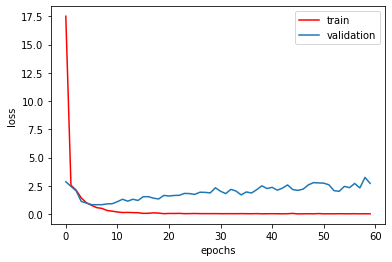


Train vs. Validation Accuracy


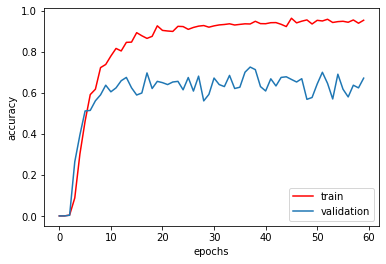

In [ ]:
print('Train vs. Validation loss')
x = np.arange(0, len(history_model.history['loss']))
plt.plot(x,history_model.history['loss'], color='red', label='train')
plt.plot(x,history_model.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

print('\nTrain vs. Validation Accuracy')
x = np.arange(0, len(history_model.history['multi_acc']))
plt.plot(x,history_model.history['multi_acc'], color='red', label='train')
plt.plot(x,history_model.history['val_multi_acc'], label='validation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()

## Test the end to end system using the test set and trained model

Test set images : plates_images_test

Test set labels : plates_test

In [ ]:
# plate_images_test,  plates_test 

model = build_model(n_classes)

#load the best model
model.load_weights(best_model)

In [ ]:
def evaluate_model(model, n_classes, n_rounds=5, n_display_samples=10, batch_size=64, seed=42):
  # Data loader for test images
  iter_test = image_transformer.flow(plate_images_test, plates_test,
                                            batch_size=batch_size, seed=seed)
  # steps per epoch for test images
  steps_test = int(np.ceil(len(plate_images_test) / batch_size)) 
  
  
  # Number of test samples and correct predictions
  n_test = n_correct = 0
  # Correct and incorrect samples
  correct_samples = []
  incorrect_samples = []
  
  for _ in range(n_rounds*steps_test):
      images_batch, texts_batch = next(iter_test)
      
      preds = model.predict(images_batch)

      preds_reshape = preds.reshape(7*len(preds), n_classes)

      decoded = lb.inverse_transform(preds_reshape)

      preds_grouped = list(group_every(decoded,7)) # list of lists where the sublists are lists of chars

      # convert the encoded province char back to the chinese char for printing
      for i, pred in enumerate(preds_grouped):
        if len(pred[0]) > 1:
          preds_grouped[i][0] = str(chr(int(pred[0])))

      preds_formatted = [''.join(x) for x in preds_grouped] # list of strings that are the predictions 

      for i in range(len(preds)):
          n_test += 1

          texts_batch[i][0] = str(chr(int(texts_batch[i][0])))

          if preds_formatted[i] == ''.join(texts_batch[i]):
              n_correct += 1
              if n_correct <= n_display_samples:
                  correct_samples.append((np.reshape(images_batch[i], (32, 224)), preds_formatted[i]))
          else: 
              if n_test - n_correct <= n_display_samples:
                  incorrect_samples.append((np.reshape(images_batch[i], (32, 224)), preds_formatted[i], ''.join(texts_batch[i])))
      
  # Show statistics
  print("# of test license plates:", n_test)
  print("# correctly recognized plates:", n_correct)
  print("Accuracy:", n_correct/n_test, "\n")
  
  # Show all correct predictions
  print_images(
      unzip(correct_samples)[0],
      texts=[f"Correct: {actual}" for _, actual in correct_samples],
      n_rows=2,
      fig_size=(30, 6),
      text_center=(0.5, -0.55)
  )

  # Show all incorrect predictions
  print_images(
      unzip(incorrect_samples)[0],
      texts=[
          f"Prediction: {pred}\nActual: {actual}" \
          for _, pred, actual in incorrect_samples
      ],
      n_rows=2,
      fig_size=(30, 8),
      text_center=(0.5, -0.55)
  )

# of test license plates: 1460
# correctly recognized plates: 1015
Accuracy: 0.6952054794520548 

Figure(2160x432)
Figure(2160x576)


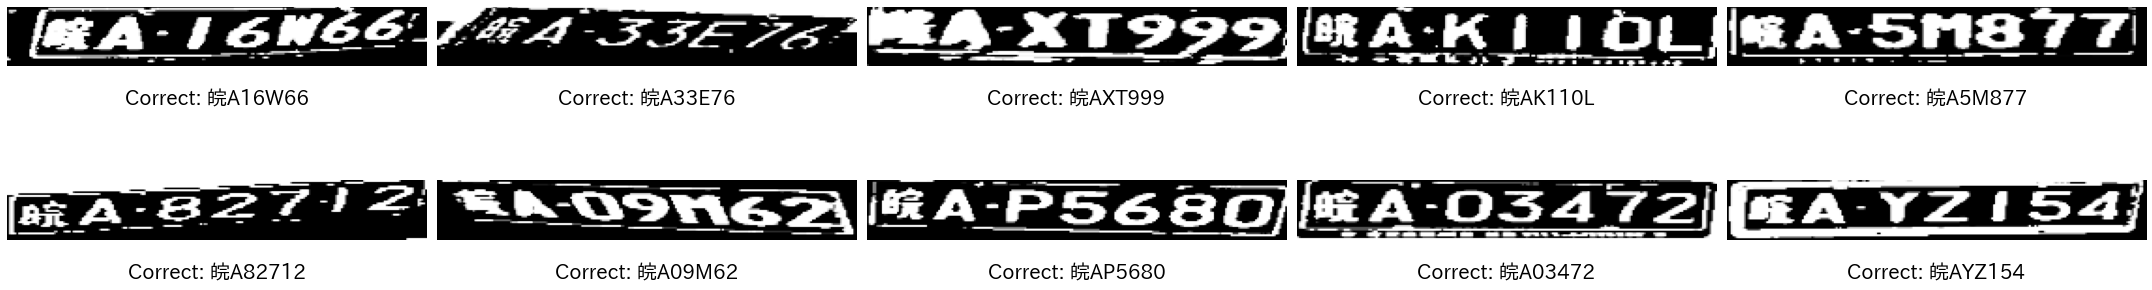

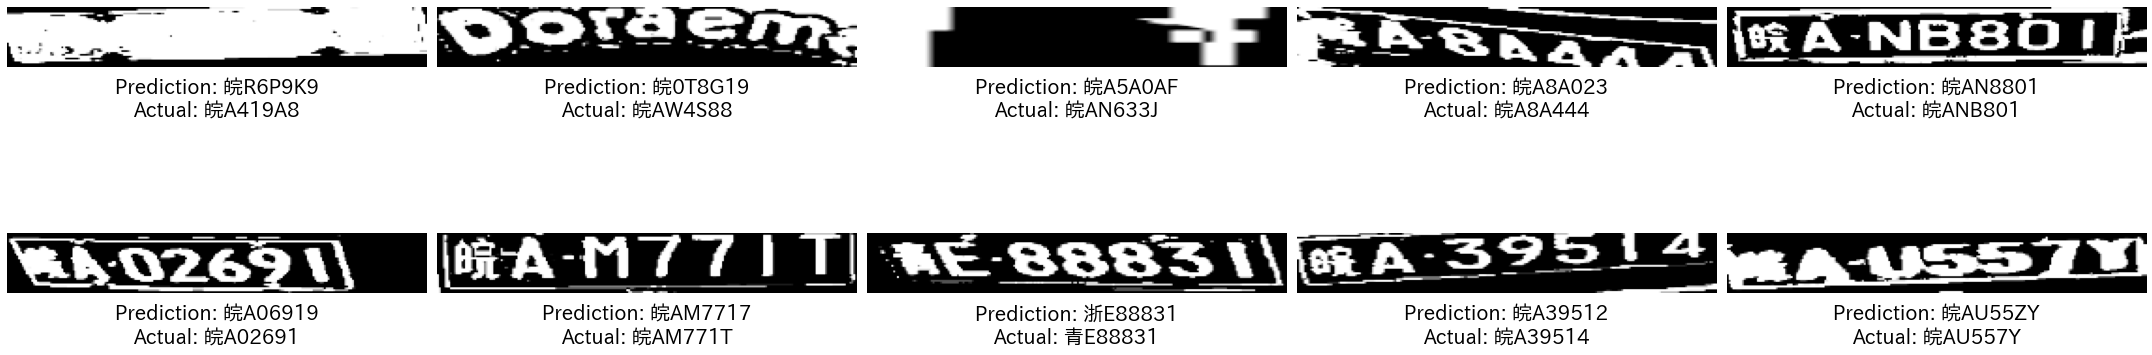

In [ ]:
evaluate_model(model, n_classes)